In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

# Mounting and Installation of Package: Only on Google Colab

# Library Imports

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special

# Data Generation

Data are generated as:
\begin{align}
x[1:] \sim~& U[-1, 1]^{d-1}\\
x[0] \sim~& Binomial(1, .5 + .3 \cdot g(x))\\
y \sim~& x[0] + g(x) + N(0, 1)
\end{align}
We consider several non-linear functions $g$. We then want to learn some average moment $E[m(x, y; f)]$ of the regression function 
\begin{equation}
f(x) = E[y\mid x] = x[0] + g(x).
\end{equation}

In [3]:
def nonlin(x):
    # return 1.5 * (x[:, 1]**2)
    # return x[:, 1]
    # return scipy.special.expit(10 * x[:, 1])
    return np.abs(x[:, 1])
    # return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 + .3 * nonlin(X)

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p, treatment='binary'):
    X = np.random.uniform(-1, 1, size=(n, p))
    if treatment == 'binary':
        X[:, 0] = np.random.binomial(1, true_propensity(X))
    else:
        X[:, 0] = true_propensity(X) + np.random.normal(size=(n,))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
treatment = 'binary'
# treatment = 'continuous'
n = 2000
p = 10
X, y = gen_data(n, p, treatment)
X_test, y_test = gen_data(n, p, treatment)

# Moment Definition

### ATE Moment

In [4]:
def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    return t1 - t0

def true_reisz(x, propensity):
    return (x[:, 0]==1) / propensity(x) - (x[:, 0]==0)/(1 - propensity(x))

### Policy Moment

In [8]:
policy = lambda x: scipy.special.expit(10*x[:, 1])

def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    p1 = policy(x)
    if len(t1.shape) > 1:
        p1 = p1.reshape(-1, 1)
    return t1 * p1 + t0 * (1 - p1) 

def true_reisz(x, propensity):
    p1 = policy(x)
    prop1 = propensity(x)
    return p1 * (x[:, 0]==1) / prop1 + (1 - p1) * (x[:, 0]==0)/(1 - prop1)

### X-Transportation

The true Reisz is more complex here due to the correlation of T=X[:, 0] and X[:, 1]. We have, let $t=X[:, 0]$ and $x=X[:, 1]$. Then the relevant ratios are:
\begin{align}
\frac{f_{trans}(t, x)}{f(t, x)} = \frac{Pr[T=t|X=t^{-1}(x)] f(t^{-1}(x)) (t^{-1}(x))'}{Pr[T=t|X=x] f(x)} 
\end{align}
When $x$ is drawn from the uniform distribution, then the density if constant and the above simplifies to:
\begin{align}
\frac{f_{trans}(t, x)}{f(t, x)}= \frac{Pr[T=t|X=t^{-1}(x)] (t^{-1}(x))'}{Pr[T=t|X=x]}
\end{align}

In [ ]:
trans = lambda x: (1 + x)**(1/2)/2**(1/2)
invtrans = lambda u: 2 * (u**2) - 1
grad_invtrans = lambda u: 4 * u

def moment_fn(x, test_fn):
    tx =  np.hstack([x[:, [0]], trans(x[:, [1]]), x[:, 2:]])
    return test_fn(tx) - test_fn(x)

def true_reisz(x, propensity=None):
    invtx = np.hstack([x[:, [0]], invtrans(x[:, [1]]), x[:, 2:]])
    out0 = np.clip(propensity(invtx) * grad_invtrans(x[:, 1]) / propensity(x), 0, np.inf)
    out1 = np.clip((1 - propensity(invtx)) * grad_invtrans(x[:, 1]) / (1 - propensity(x)), 0, np.inf)
    return out0 * x[:, 0] + out1 * (1 - x[:, 0]) - 1

# Adversarial Reisz Estimator

In [57]:
from advreisz.linear import SparseLinearAdvRiesz
from advreisz.linear.utilities import SeparateFeaturizer, CoordinatePolynomialFeatures

In [84]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import Pipeline

# feat = Pipeline([('p', CoordinatePolynomialFeatures(degree=3))])
feat = Pipeline([('p', PolynomialFeatures(degree=3, include_bias=False))])
# feat = Pipeline([('nys', Nystroem(n_components=100, kernel='rbf', gamma=5, degree=3))])
# feat = Pipeline([('nys', RBFSampler(n_components=100, gamma=2))])
feat.steps.append(('s', StandardScaler()))
feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
# feat = Pipeline([('p', SeparateFeaturizer(feat))])
# feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=50000, lambda_theta=0.01, B=10,
                             tol=0.00001).fit(X)

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "


In [85]:
coefs = splin.coef
print("Maximum violation: ", splin.max_violation_)
#print("Estimated non-zero coefs: ", np.array(list(zip(splin.get_feature_names(), coefs))))
print("Min/Max: ", splin.min_response_loss_, splin.max_response_loss_)
print("Dualit Gap: ", splin.duality_gap_)
print("Iters: ", splin.n_iters_)

Maximum violation:  0.015416993304562806
Min/Max:  0.024175023953648657 0.025299242718834658
Dualit Gap:  0.0011242187651860011
Iters:  100000


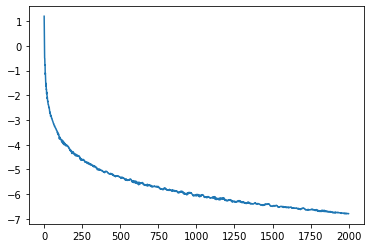

In [86]:
plt.plot(np.log(np.array(splin.duality_gaps)))
plt.show()

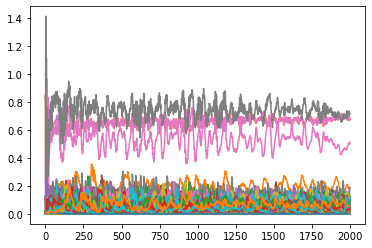

In [87]:
plt.plot(np.exp(np.array(splin.log_theta_list)))
plt.show()

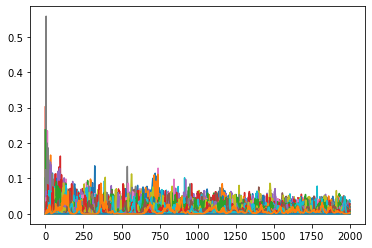

In [88]:
plt.plot(np.exp(np.array(splin.log_w_list)))
plt.show()

# Evaluation of Learned Reisz Representer

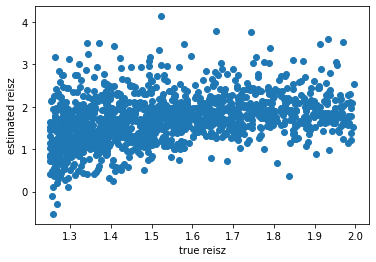

In [89]:
if treatment == 'binary': 
    plt.figure()
    treated = (X_test[:, 0] == 1)
    plt.scatter(true_reisz(X_test[treated], true_propensity), splin.predict(X_test[treated]))
    plt.xlabel('true reisz')
    plt.ylabel('estimated reisz')
    plt.show()

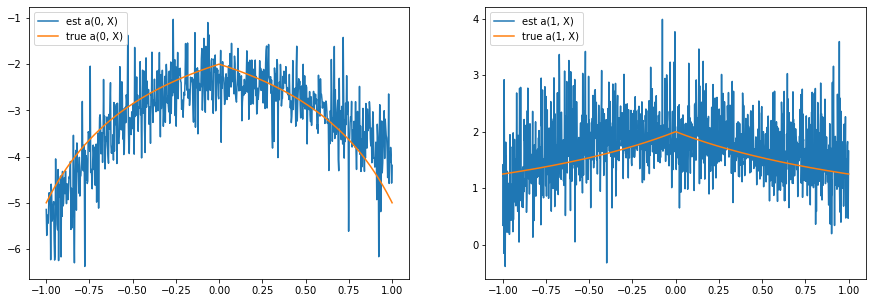

In [90]:
if treatment == 'binary': 
    plt.figure(figsize=(15, 5))
    error = true_reisz(X_test, true_propensity) - splin.predict(X_test)
    plt.title("RMSE: {:.3f}, MAE: {:.3f}".format(np.sqrt(np.mean(error**2)), np.mean(np.abs(error))))
    for t in [0, 1]:
        plt.subplot(1, 2, t + 1)
        treated = (X_test[:, 0] == t)
        Xtreated = X_test[treated].copy()
        Xtreated[:, 1] = np.linspace(-1, 1, Xtreated.shape[0])
        plt.plot(Xtreated[:, 1], splin.predict(Xtreated), label='est a({}, X)'.format(t))
        plt.plot(Xtreated[:, 1], true_reisz(Xtreated, true_propensity), label='true a({}, X)'.format(t))
        plt.legend()
    plt.show()

# Debiased Average Moment Estimate

Applying the learned Reisz representer in order to debias a preliminary regression based model of the ATE

In [91]:
def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [92]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline

est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
if treatment == 'binary':
    propensity = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', LogisticRegressionCV())]).fit(X[:, 1:], X[:, 0])

In [93]:
a_test = splin.predict(X_test)
true_ate = np.mean(moment_fn(X_test, true_f))
biased_ate = np.mean(moment_fn(X_test, est.predict))
reisz_ate = np.mean(a_test * y_test)
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X_test, est.predict) + a_test * (y_test - est.predict(X_test)))
if treatment == 'binary':
    naive_ate = np.mean(y_test[X_test[:, 0]==1]) - np.mean(y_test[X_test[:, 0]==0])
    invp_test = true_reisz(X_test, lambda x: propensity.predict_proba(x[:, 1:])[:, 1])
    ips_ate = np.mean(invp_test * y_test)
    dr_ate = biased_ate + np.mean(invp_test * (y_test - est.predict(X_test)))

In [94]:
print("True ATE: {:.3f}".format(true_ate))
print("Lasso Regression based Estimate: {:.3f}".format(biased_ate))
print("IPS estimate with adversarial reisz: {:.3f}".format(reisz_ate))
print("DR estimate with adversarial reisz: {:.3f} ({:.3f}, {:.3f})".format(dr_reisz_ate, dr_reisz_low, dr_reisz_up))
if treatment == 'binary':
    print("Mean of Treated - Mean of Untreated: {:.3f}".format(naive_ate))
    print("IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): {:.3f}".format(ips_ate))
    print("DR estimate with explict propensity based reisz estimate: {:.3f}".format(dr_ate))

True ATE: 1.000
Lasso Regression based Estimate: 0.719
IPS estimate with adversarial reisz: 1.191
DR estimate with adversarial reisz: 1.073 (0.969, 1.177)
Mean of Treated - Mean of Untreated: 1.162
IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): 1.188
DR estimate with explict propensity based reisz estimate: 1.159


In [95]:
dr_reisz_ate = []
reisz_ate = []
biased_ate = []
dr_reisz_cov = []
reisz_cov = []
for exp in range(1000):
    Xboot, yboot = gen_data(n, p, treatment)
    aboot = splin.predict(Xboot)
    drm, drl, dru = mean_ci(moment_fn(Xboot, est.predict) + aboot * (yboot - est.predict(Xboot)))
    rm, rl, ru = mean_ci(aboot * yboot)
    dr_reisz_ate.append(drm)
    reisz_ate.append(rm)
    dr_reisz_cov.append((true_ate <= dru) & (true_ate >= drl))
    reisz_cov.append((true_ate <= ru) & (true_ate >= rl))

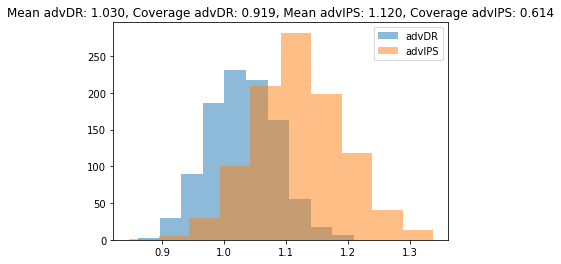

In [96]:
plt.title("Mean advDR: {:.3f}, Coverage advDR: {:.3f}, "
          "Mean advIPS: {:.3f}, Coverage advIPS: {:.3f}".format(np.mean(dr_reisz_ate),
                                                               np.mean(dr_reisz_cov),
                                                               np.mean(reisz_ate),
                                                               np.mean(reisz_cov)))
plt.hist(np.array(dr_reisz_ate), alpha=.5, label='advDR')
plt.hist(np.array(reisz_ate), alpha=.5, label='advIPS')
plt.legend()
plt.show()

In [31]:
import pandas as pd

df = pd.read_csv('rahul/sim_1.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values

In [32]:
feat = Pipeline([('p', PolynomialFeatures(degree=3, include_bias=False))])
feat.steps.append(('s', StandardScaler()))
feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=50000, lambda_theta=0.01, B=10,
                             tol=0.00001).fit(X)

NameError: name 'SparseLinearAdvRiesz' is not defined

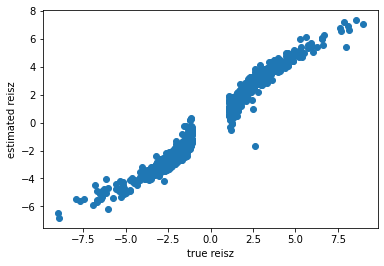

In [24]:
plt.figure()
treated = (X_test[:, 0] == 1)
plt.scatter(df['rr'].values, splin.predict(X))
plt.xlabel('true reisz')
plt.ylabel('estimated reisz')
plt.show()

In [25]:
a_test = splin.predict(X)
est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

In [26]:
dr_reisz_ate, dr_reisz_low, dr_reisz_up 

(2.171419091455974, 2.047085448705302, 2.2957527342066464)

In [27]:
import pandas as pd
from joblib import Parallel, delayed

def exp(it):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    feat = Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False))])
    feat.steps.append(('s', StandardScaler()))
    feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
    splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                                n_iter=50000, lambda_theta=0.01, B=10,
                                tol=0.00001).fit(X)
    a_test = splin.predict(X)
    est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
    return mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

true = 2.2

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in np.arange(1, 101).astype(int))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


In [41]:
results = np.array(results)

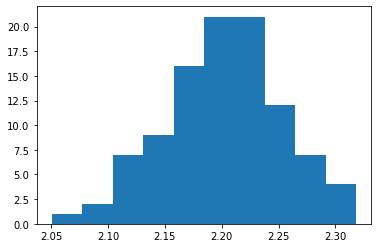

In [42]:
plt.hist(results[:, 0])
plt.show()

In [43]:
np.mean((results[:, 1] <= true) & (results[:, 2] >= true))

0.97

In [44]:
np.std(results[:, 0])

0.05116563577507155

In [37]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

def exp(it):
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    a_pred = np.zeros(X.shape[0])
    reg_pred = np.zeros(X.shape[0])
    moment_pred = np.zeros(X.shape[0])
    for train, test in KFold(n_splits=5).split(X):
        feat = Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False))])
        feat.steps.append(('s', StandardScaler()))
        feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
        splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                                    n_iter=50000, lambda_theta=0.01, B=10,
                                    tol=0.00001).fit(X[train])
        a_pred[test] = splin.predict(X[test])
        est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X[train], y[train])
        reg_pred[test] = est.predict(X[test])
        moment_pred[test] = moment_fn(X[test], est.predict)

    return mean_ci(moment_pred + a_pred * (y - reg_pred))

true = 2.2

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in np.arange(1, 101).astype(int))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.2min finished


In [106]:
import joblib
import os
true = 2.2
res = {}
plot = False
n_samples_list = [100, 200, 300, 500, 700, 1000, 2000]
start_sample_list = [1, 21, 41, 61, 81]
sample_its = 20
folder = os.path.join('amlt', 'sought-asp')
for n_samples in n_samples_list:
    res[f'n={n_samples}'] = {}
    for name, var in [('adv_splin', f'splin_nocfit_n_{n_samples}'),
                      ('adv_splin_cfit', f'splin_5fold_cfit_n_{n_samples}')]:
        results = []
        for start_sample in start_sample_list:
            results += joblib.load(os.path.join(folder, f'kernel_{n_samples}_0_1_{start_sample}_{sample_its}',
                                                f'{var}_{start_sample}_{sample_its}.jbl'))
        results = np.array(results)
        if plot:
            plt.hist(results[:, 0])
            plt.title(f'{var}, n={n_samples}')
            plt.show()
        res[f'n={n_samples}'][name] = {
                                 'cov': np.mean((results[:, 1] <= true) & (results[:, 2] >= true)),
                                 'bias': np.mean(results[:, 0] - true),
                                 'rmse': np.sqrt(np.mean((results[:, 0] - true)**2)),
                                 'ci_length': np.mean(results[:, 2] - results[:, 1])}
    res[f'n={n_samples}'] = pd.DataFrame(res[f'n={n_samples}'])

pd.concat(res, axis=0)

adv_splin  adv_splin_cfit
n=100  cov         0.890000        0.980000
       bias       -0.040589       -0.026243
       rmse        0.289682        0.358832
       ci_length   0.975084        1.485293
n=200  cov         0.950000        0.980000
       bias       -0.040964       -0.045957
       rmse        0.176788        0.205110
       ci_length   0.697905        0.906884
n=300  cov         0.960000        0.970000
       bias       -0.006708       -0.003591
       rmse        0.138345        0.153311
       ci_length   0.570643        0.690713
n=500  cov         0.980000        0.990000
       bias       -0.002798        0.002748
       rmse        0.101164        0.101828
       ci_length   0.440139        0.496921
n=700  cov         0.990000        1.000000
       bias       -0.002351       -0.000576
       rmse        0.086012        0.089115
       ci_length   0.371427        0.404549
n=1000 cov         0.950000        0.970000
       bias       -0.005102       -0.003105
       rmse        0.081075        0.081938
       ci_length   0.310271        0.330241
n=2000 cov         0.970000        0.980000
       bias       -0.001420       -0.001636
       rmse        0.051184        0.051242
       ci_length   0.219879        0.227194

# Kernel Experiments

In [70]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [162]:
def nonlin(x):
#     return 1.5 * (x[:, 1]**2)
    return x[:, 1]
    # return scipy.special.expit(10 * x[:, 1])
    # return np.abs(x[:, 1])
    return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 + .3 * nonlin(X)

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p, treatment='binary'):
    X = np.random.uniform(-1, 1, size=(n, p))
    if treatment == 'binary':
        X[:, 0] = np.random.binomial(1, true_propensity(X))
    else:
        X[:, 0] = true_propensity(X) + np.random.normal(size=(n,))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
treatment = 'binary'
# treatment = 'continuous'
n = 2000
p = 10
X, y = gen_data(n, p, treatment)
synth = True

In [163]:
def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    return t1 - t0

def true_reisz(x, propensity):
    return (x[:, 0]==1) / propensity(x) - (x[:, 0]==0)/(1 - propensity(x))

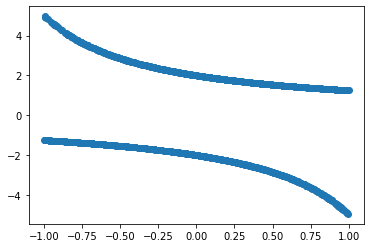

In [164]:
plt.scatter(X[:, 1], true_reisz(X, true_propensity))
plt.show()

In [186]:
import pandas as pd
df = pd.read_csv(f'rahul/sim_1.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
synth = False

In [187]:
n_samples = 500
X, y = X[:n_samples], y[:n_samples]

In [188]:
Xtest = X.copy()
ytest = y.copy()

In [189]:
from advreisz.kernel import AdvKernelReisz

In [206]:
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, pairwise_kernels
from kernel_experiments import AutoKernel, prod_kernel
from sklearn.model_selection import train_test_split

kernel = AutoKernel(type='median')
# kernel = lambda X, Y=None: prod_kernel(X, Y=Y, gamma=.1)
# kernel = lambda X, Y=None: pairwise_kernels(X, Y=Y, metric='poly', degree=3)
Xtrain, Xval = train_test_split(X, test_size=.5)

reglist = np.logspace(-7, -2, 6)
scores = [AdvKernelReisz(kernel=kernel, regm=6*reg, regl=reg).fit(Xtrain).score(Xval)
          for reg in reglist]
print(scores)
opt = reglist[np.argmin(scores)]
print(opt, np.min(scores))

[1.087390178827876, 0.8095982400711146, 0.24536992067215008, 0.052925291009182, 1516.736289607456, 2828.9649473831196]
0.0001 0.052925291009182


In [207]:
splin = AdvKernelReisz(kernel=kernel, regm=6*opt, regl=opt).fit(X)

In [208]:
splin.score_train_

5.553534087991089

In [209]:
from kernel_experiments import mean_ci

est = Pipeline([('p', PolynomialFeatures(degree=1)), ('sc', StandardScaler()),
                ('l', Lasso(alpha=.1))]).fit(X, y)
a_test = splin.predict(Xtest)
mean_ci(moment_fn(Xtest, est.predict) + a_test * (ytest - est.predict(Xtest)))

(2.137799526966973, 1.9251655890150345, 2.350433464918911)

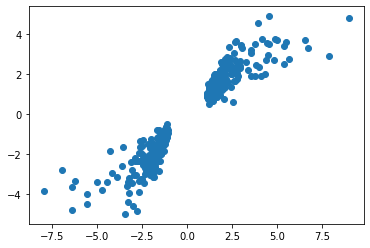

In [210]:
if not synth:
    plt.scatter(df['rr'][:n_samples], a_test)
    plt.show()

In [211]:
if synth:
    plt.scatter(true_reisz(Xtest, true_propensity), a_test)
    plt.show()
    plt.scatter(X[:, 1], a_test)
    plt.show()

In [212]:
from advreisz.kernel import KernelReisz

In [213]:
Xtrain, Xval = train_test_split(X, test_size=.5)

reglist = np.logspace(-6, -1, 6)
scores = [KernelReisz(kernel=kernel, regl=reg).fit(Xtrain).score(Xval)
          for reg in reglist]
print(scores)
opt = reglist[np.argmin(scores)]
print(opt, np.min(scores))

[3328700.0143836895, 33857.19262508157, 376.5928178789856, 0.9416513162526993, -4.097117236476154, -2.758815098580032]
0.01 -4.097117236476154


In [214]:
splin = KernelReisz(kernel=kernel, regl=opt).fit(X)

In [215]:
est = Pipeline([('p', PolynomialFeatures(degree=1)), ('sc', StandardScaler()),
                ('l', Lasso(alpha=.1))]).fit(X, y)
a_test = splin.predict(Xtest)
mean_ci(moment_fn(Xtest, est.predict) + a_test * (ytest - est.predict(Xtest)))

(2.1448831898393954, 1.964122803906552, 2.3256435757722387)

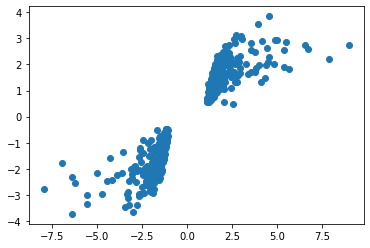

In [216]:
if not synth:
    plt.scatter(df['rr'][:n_samples], a_test)
    plt.show()

In [217]:
if synth:
    plt.scatter(true_reisz(Xtest, true_propensity), a_test)
    plt.show()
    plt.scatter(X[:, 1], a_test)
    plt.show()

In [28]:
from kernel_experiments import kernel_experiments
n_samples_list = [500]
kernel_experiments(n_samples_list, kernelid=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


In [29]:
import joblib
import os
true = 2.2
res = {}
plot = False
n_samples_list = [100, 500]
for n_samples in n_samples_list:
    res[f'n={n_samples}'] = {}
    for name, var in [('adv_kreisz', f'advreisz_nocfit_n_{n_samples}.jbl'),
                        ('adv_kreisz_cfit', f'advreisz_5fold_cfit_n_{n_samples}.jbl'),
                        ('kreisz', f'kernelreisz_nocfit_n_{n_samples}.jbl'), 
                        ('kreisz_cfit', f'kernelreisz_5fold_cfit_n_{n_samples}.jbl')]:
        results = joblib.load(var)
        results = np.array(results)
        if plot:
            plt.hist(results[:, 0])
            plt.title(f'{var}, n={n_samples}')
            plt.show()
        res[f'n={n_samples}'][name] = {'cov': np.mean((results[:, 1] <= true) & (results[:, 2] >= true)),
                                 'bias': np.mean(results[:, 0] - true),
                                 'rmse': np.sqrt(np.mean((results[:, 0] - true)**2)),
                                 'ci_length': np.mean(results[:, 2] - results[:, 1])}
    res[f'n={n_samples}'] = pd.DataFrame(res[f'n={n_samples}'])

In [30]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(pd.concat(res, axis=0))

adv_kreisz  adv_kreisz_cfit  kreisz  kreisz_cfit
n=100 cov              0.86             0.85    0.87         0.99
      bias            -0.02            -0.02   -0.01         0.25
      rmse             0.27             0.29    0.28         1.48
      ci_length        0.84             0.91    0.91         7.06
n=500 cov              0.97             0.98    0.97         0.98
      bias             0.01             0.02    0.01         0.16
      rmse             0.11             0.12    0.11         0.47
      ci_length        0.45             0.55    0.49         2.34

In [263]:
import joblib
import os
true = 2.2
res = {}
plot = False
n_samples_list = [100, 200, 300, 500, 700, 1000, 2000]
folder = os.path.join('amlt', 'helpful-polliwog')
for kernelid in [2, 3]:
    res[f'kernel={kernelid}'] = {}
    for n_samples in n_samples_list:
        res[f'kernel={kernelid}'][f'n={n_samples}'] = {}
        for name, var in [('adv_kreisz', f'advreisz_nocfit_n_{n_samples}.jbl'),
                            ('adv_kreisz_cfit', f'advreisz_5fold_cfit_n_{n_samples}.jbl'),
                            ('kreisz', f'kernelreisz_nocfit_n_{n_samples}.jbl'), 
                            ('kreisz_cfit', f'kernelreisz_5fold_cfit_n_{n_samples}.jbl')]:
            results = joblib.load(os.path.join(folder, f'kernel_{n_samples}_{kernelid}', var))
            results = np.array(results)
            if plot:
                plt.hist(results[:, 0])
                plt.title(f'{var}, n={n_samples}')
                plt.show()
            res[f'kernel={kernelid}'][f'n={n_samples}'][name] = {
                                     'cov': np.mean((results[:, 1] <= true) & (results[:, 2] >= true)),
                                     'bias': np.mean(results[:, 0] - true),
                                     'rmse': np.sqrt(np.mean((results[:, 0] - true)**2)),
                                     'ci_length': np.mean(results[:, 2] - results[:, 1])}
        res[f'kernel={kernelid}'][f'n={n_samples}'] = pd.DataFrame(res[f'kernel={kernelid}'][f'n={n_samples}'])
    res[f'kernel={kernelid}'] = pd.concat(res[f'kernel={kernelid}'], axis=0)

In [264]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(pd.concat(res, axis=1))

kernel=2                                      kernel=3  \
                 adv_kreisz adv_kreisz_cfit kreisz kreisz_cfit adv_kreisz   
n=100  cov             0.86            0.86   0.89        0.99       0.86   
       bias           -0.02           -0.02  -0.01        0.24      -0.02   
       rmse            0.27            0.29   0.28        1.46       0.27   
       ci_length       0.86            0.95   0.93        6.84       0.84   
n=200  cov             0.93            0.96   0.95        1.00       0.93   
       bias           -0.02           -0.02  -0.01        0.15      -0.02   
       rmse            0.17            0.19   0.18        0.78       0.17   
       ci_length       0.66            0.77   0.72        4.16       0.65   
n=300  cov             0.93            0.96   0.94        0.99       0.93   
       bias            0.01            0.02   0.01        0.18       0.01   
       rmse            0.14            0.16   0.15        0.64       0.14   
       ci_length       0.56            0.67   0.61        3.16       0.55   
n=500  cov             0.97            0.98   0.97        0.98       0.97   
       bias            0.01            0.02   0.01        0.14       0.01   
       rmse            0.11            0.12   0.11        0.43       0.11   
       ci_length       0.45            0.56   0.49        2.16       0.45   
n=700  cov             0.97            0.97   0.97        0.97       0.96   
       bias            0.01            0.02   0.02        0.10       0.01   
       rmse            0.09            0.11   0.10        0.36       0.10   
       ci_length       0.39            0.49   0.42        1.67       0.38   
n=1000 cov             0.95            0.96   0.92        0.96       0.94   
       bias            0.01            0.02   0.02        0.07       0.01   
       rmse            0.09            0.10   0.10        0.29       0.09   
       ci_length       0.33            0.42   0.36        1.26       0.33   
n=2000 cov             0.98            1.00   0.98        1.00       0.97   
       bias            0.01            0.01   0.01        0.01       0.01   
       rmse            0.05            0.06   0.06        0.13       0.05   
       ci_length       0.24            0.30   0.26        0.75       0.24   

                                                     
                 adv_kreisz_cfit kreisz kreisz_cfit  
n=100  cov                  0.85   0.87        0.99  
       bias                -0.02  -0.01        0.25  
       rmse                 0.29   0.28        1.48  
       ci_length            0.91   0.91        7.06  
n=200  cov                  0.94   0.95        1.00  
       bias                -0.02  -0.01        0.17  
       rmse                 0.18   0.18        0.82  
       ci_length            0.74   0.71        4.40  
n=300  cov                  0.94   0.94        0.99  
       bias                 0.02   0.01        0.20  
       rmse                 0.16   0.15        0.68  
       ci_length            0.65   0.60        3.38  
n=500  cov                  0.98   0.97        0.98  
       bias                 0.02   0.01        0.16  
       rmse                 0.12   0.11        0.47  
       ci_length            0.55   0.49        2.34  
n=700  cov                  0.97   0.97        0.97  
       bias                 0.02   0.02        0.12  
       rmse                 0.11   0.10        0.39  
       ci_length            0.48   0.42        1.81  
n=1000 cov                  0.96   0.92        0.96  
       bias                 0.02   0.02        0.08  
       rmse                 0.10   0.10        0.32  
       ci_length            0.41   0.36        1.38  
n=2000 cov                  1.00   0.98        1.00  
       bias                 0.01   0.01        0.01  
       rmse                 0.06   0.06        0.14  
       ci_length            0.30   0.26        0.82

In [260]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(pd.concat(res, axis=1).to_latex(bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
       &           & \multicolumn{4}{l}{kernel=0} & \multicolumn{4}{l}{kernel=1} & \multicolumn{4}{l}{kernel=2} & \multicolumn{4}{l}{kernel=3} \\
       &           & adv\_kreisz & adv\_kreisz\_cfit & kreisz & kreisz\_cfit & adv\_kreisz & adv\_kreisz\_cfit & kreisz & kreisz\_cfit & adv\_kreisz & adv\_kreisz\_cfit & kreisz & kreisz\_cfit & adv\_kreisz & adv\_kreisz\_cfit & kreisz & kreisz\_cfit \\
\midrule
\multirow{4}{*}{\textbf{n=100}} & \textbf{cov} &       0.71 &            0.74 &   0.76 &        0.99 &       0.86 &            0.87 &   0.89 &        0.98 &       0.86 &            0.86 &   0.89 &        0.99 &       0.86 &            0.85 &   0.87 &        0.99 \\
       & \textbf{bias} &      -0.08 &           -0.07 &  -0.07 &        0.24 &      -0.02 &           -0.01 &  -0.01 &        0.24 &      -0.02 &           -0.02 &  -0.01 &        0.24 &      -0.02 &           -0.02 &  -0.01 &        0.25 \\
       & \textbf{rmse} &       0.29 & 